# Analyse des occupations

Question : quelles sont les occupations principales des intellectuels ?

## Importation des librairies

In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

In [3]:
from ipywidgets import (
    interact, IntSlider, Checkbox,
    interactive, SelectMultiple)

In [4]:
import sparql_functions as spqf

In [5]:
reload(spqf)

<module 'sparql_functions' from 'C:\\jupyter_notebooks\\JS_intellectuels\\sparql_functions.py'>

## Préparation des données

In [6]:
db = 'data/intellectuels.db'

In [7]:
interest = """
WITH tw0 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END occupation
FROM
	property
WHERE
	property IN ('http://dbpedia.org/ontology/occupation')
), tw1 AS (
SELECT GROUP_CONCAT(value) birth_dates, uri_entity, count(*) as eff
FROM property p
WHERE p.property LIKE '%birthD%' OR p.property LIKE '%birthY%'
GROUP BY uri_entity)
SELECT tw1.uri_entity, tw1.birth_dates, occupation
FROM tw1, tw0
WHERE tw1.uri_entity = tw0.uri_entity;
"""

In [8]:
# Connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### Exécuter la requête sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c.execute(interest)
result_q = []
result_q = c.fetchall()

# Fermer la connexion et afficher les cinq premiers résultats
cn.close()
print(len(result_q))
result_q[:10]

54731


[('http://dbpedia.org/resource/9th_Wonder',
  '1975-01-15,1975,1975-01-15',
  '9th_Wonder_production_discography'),
 ('http://dbpedia.org/resource/9th_Wonder',
  '1975-01-15,1975,1975-01-15',
  'Rapping'),
 ('http://dbpedia.org/resource/9th_Wonder',
  '1975-01-15,1975,1975-01-15',
  'Record_executive'),
 ("http://dbpedia.org/resource/A'Lelia_Bundles",
  '1952-06-07,1952,1952,1952-06-07',
  "A'Lelia_Bundles__PersonFunction__1"),
 ('http://dbpedia.org/resource/A.B.C._Whipple',
  '1918-07-15,1918,1918-07-15',
  'Historian'),
 ('http://dbpedia.org/resource/A.G._Lafley',
  '1947-06-13,1947,1947,1947-06-13',
  'A.G._Lafley__PersonFunction__1'),
 ('http://dbpedia.org/resource/A.G._Lafley',
  '1947-06-13,1947,1947,1947-06-13',
  'Procter_&_Gamble'),
 ('http://dbpedia.org/resource/A._Arthur_Giddon',
  '1909-04-26,1909,1909,1909-04-26',
  'A._Arthur_Giddon__PersonFunction__1'),
 ('http://dbpedia.org/resource/A._Arthur_Giddon',
  '1909-04-26,1909,1909,1909-04-26',
  'Lawyer'),
 ('http://dbpedia.o

In [9]:
# Crée un DataFrame avec les résultats de la requête concernant l'année de naissance et la nationalité
df_result = pd.DataFrame(result_q)
df_result.columns =['uri_entity','dates', 'occupation']
# Affiche les cinq premiers résultats
df_result [:5]

,uri_entity,dates,occupation
0,http://dbpedia.org/resource/9th_Wonder,"1975-01-15,1975,1975-01-15",9th_Wonder_production_discography
1,http://dbpedia.org/resource/9th_Wonder,"1975-01-15,1975,1975-01-15",Rapping
2,http://dbpedia.org/resource/9th_Wonder,"1975-01-15,1975,1975-01-15",Record_executive
3,http://dbpedia.org/resource/A'Lelia_Bundles,"1952-06-07,1952,1952,1952-06-07",A'Lelia_Bundles__PersonFunction__1
4,http://dbpedia.org/resource/A.B.C._Whipple,"1918-07-15,1918,1918-07-15",Historian


### Nettoyer les années de naissance

In [10]:
# Extraire les années
listeDateNaiss = []
annee = re.compile(r'\d{4}')

for l in result_q:
    listeDateNaiss.append(annee.findall(l[0])) 
    
# Vérifier que la longueur de la liste corresponde aux données de la base de données
len(listeDateNaiss)

54731

In [11]:
# Extraire l'année de chaque ligne.
df_result['anneeNaiss'] = df_result['dates'].apply(lambda row: annee.findall(row)[0] if annee.findall(row) else None)  
# Affiche les cinq premiers résultats
df_result[:5]

,uri_entity,dates,occupation,anneeNaiss
0,http://dbpedia.org/resource/9th_Wonder,"1975-01-15,1975,1975-01-15",9th_Wonder_production_discography,1975
1,http://dbpedia.org/resource/9th_Wonder,"1975-01-15,1975,1975-01-15",Rapping,1975
2,http://dbpedia.org/resource/9th_Wonder,"1975-01-15,1975,1975-01-15",Record_executive,1975
3,http://dbpedia.org/resource/A'Lelia_Bundles,"1952-06-07,1952,1952,1952-06-07",A'Lelia_Bundles__PersonFunction__1,1952
4,http://dbpedia.org/resource/A.B.C._Whipple,"1918-07-15,1918,1918-07-15",Historian,1918


In [12]:
# Crée un tableau montrant les entités, leurs écoles philosophiques et leur année de naissance
occupation = df_result[['uri_entity', 'occupation', 'anneeNaiss']]
print(len(occupation))
occupation

54731


,uri_entity,occupation,anneeNaiss
0,http://dbpedia.org/resource/9th_Wonder,9th_Wonder_production_discography,1975
1,http://dbpedia.org/resource/9th_Wonder,Rapping,1975
2,http://dbpedia.org/resource/9th_Wonder,Record_executive,1975
3,http://dbpedia.org/resource/A'Lelia_Bundles,A'Lelia_Bundles__PersonFunction__1,1952
4,http://dbpedia.org/resource/A.B.C._Whipple,Historian,1918
...,...,...,...
54726,http://dbpedia.org/resource/Žarko_Puhovski,Žarko_Puhovski__PersonFunction__1,1946
54727,http://dbpedia.org/resource/Željko_Ivanek,Željko_Ivanek__PersonFunction__1,1957
54728,http://dbpedia.org/resource/Željko_Komšić,Diplomat,1964
54729,http://dbpedia.org/resource/Željko_Komšić,Politician,1964


In [13]:
# Crée un tableau montrant les entités, leurs intérêts et leur année de naissance, en ne retenant que les personnes nées après 1770
occupation_tri = df_result[['uri_entity', 'occupation', 'anneeNaiss']]
occupation_tri = occupation_tri[occupation_tri['anneeNaiss'] > '1880']
print(len(occupation_tri))
occupation_tri

46982


,uri_entity,occupation,anneeNaiss
0,http://dbpedia.org/resource/9th_Wonder,9th_Wonder_production_discography,1975
1,http://dbpedia.org/resource/9th_Wonder,Rapping,1975
2,http://dbpedia.org/resource/9th_Wonder,Record_executive,1975
3,http://dbpedia.org/resource/A'Lelia_Bundles,A'Lelia_Bundles__PersonFunction__1,1952
4,http://dbpedia.org/resource/A.B.C._Whipple,Historian,1918
...,...,...,...
54726,http://dbpedia.org/resource/Žarko_Puhovski,Žarko_Puhovski__PersonFunction__1,1946
54727,http://dbpedia.org/resource/Željko_Ivanek,Željko_Ivanek__PersonFunction__1,1957
54728,http://dbpedia.org/resource/Željko_Komšić,Diplomat,1964
54729,http://dbpedia.org/resource/Željko_Komšić,Politician,1964


### Analyse des occupations

In [14]:
# Combien de "occupation" différentes et leur répartition
groupoccupation = occupation.groupby('occupation').size()
groupoccupation.sort_values(ascending=False)

occupation
Actor                                 1064
Journalist                             790
Politician                             761
Author                                 710
Lawyer                                 658
                                      ... 
Missy_Elliott__PersonFunction__1         1
Missy_Gold__PersonFunction__1            1
Missy_Malone__PersonFunction__1          1
Missy_Rothstein__PersonFunction__1       1
1-800_Contacts                           1
Length: 31938, dtype: int64

In [15]:
# Transformer l'objet Series en DataFrame et ajouter le nom de la colonne 'effectif'
df_groupoccupation = groupoccupation.to_frame()
df_groupoccupation.columns = ['effectif']
df_groupoccupation

,effectif
occupation,
1-800_Contacts,1
117th_Air_Refueling_Wing,1
1962_Southern_Rhodesian_general_election,1
1992_United_States_presidential_election,1
1st_Armoured_Regiment_(Australia),1
...,...
Šefik_Bešlagić__PersonFunction__1,1
Šime_Ljubić__PersonFunction__1,1
Žarko_Puhovski__PersonFunction__1,1


## Filtrage des occupation

In [16]:
# Transformer l'objet Series en DataFrame et ajouter le nom de la colonne 'effectif' en ne gardant que les effectifs > 10
df_groupoccupation = groupoccupation.to_frame()
df_groupoccupation.columns = ['effectif']
df_groupoccupation = df_groupoccupation[df_groupoccupation['effectif'] > 400]
df_groupoccupation

,effectif
occupation,
Actor,1064
Actress,484
Author,710
Composer,494
Film_director,548
Historian,564
Journalist,790
Lawyer,658
Novelist,464


In [17]:
df_groupoccupation.sort_values(by='effectif', ascending=False)

,effectif
occupation,
Actor,1064
Journalist,790
Politician,761
Author,710
Lawyer,658
Historian,564
Film_director,548
Screenwriter,546
Composer,494


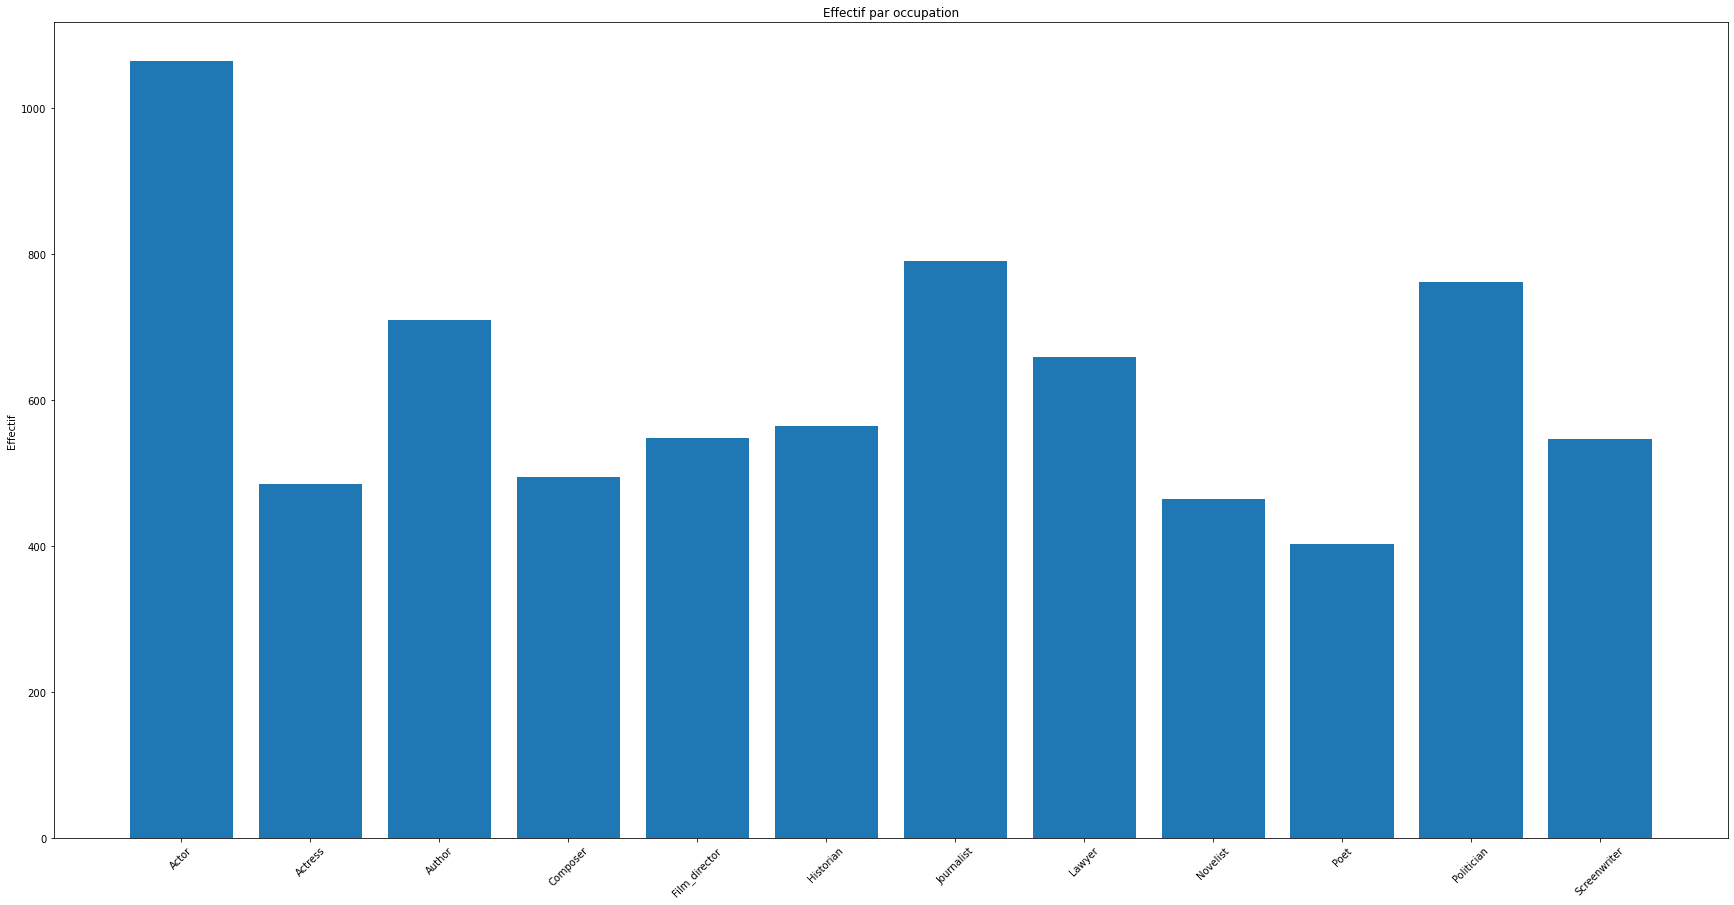

In [18]:
# Création d'un diagramme en barres montrant l'effectif d'individus par nationalité

objects = [l for l in df_groupoccupation.index]
eff = [l for l in df_groupoccupation['effectif']]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Effectif par occupation')
plt.gcf().set_size_inches(30, 15)

plt.xticks(rotation=45)
plt.show()